### Evaluation Metrics

There are several circumstances when accuracy (percentage of correct binary classifications) is not a suitable metric for evaluating a model. The 'ml-zoomcamp - week 3 - churn prediction' project is an example of such. Hence, let us first define a churn prediction model and demonstrate that accuracy is not representative of the model's effectiveness.

In [3]:
# Importing libraries

# Data manipulation
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Validation framework
from sklearn.model_selection import train_test_split

# Feature matrix formatter (dictionary vectoriser)
from sklearn.feature_extraction import DictVectorizer

# Logistic regression (sigmoid ver. linear regression)
from sklearn.linear_model import LogisticRegression

In [5]:
# Importing the data
df = pd.read_csv(r'..\Week 3\telco-customer-churn\WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Cleaning column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Storing categorical variables
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Cleaning contents of categorical series
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# Parsing totalcharges as numeric (falsely parsed as an object)
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

# Converting .churn yes/no outcomes to binary (1/0)
df.churn = (df.churn == 'yes').astype(int)

In [6]:
# Establishing validation framework using sklearn
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Defining feature matrices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Defining target-vector
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

# Removing target variable from feature matrices
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
# Numerical series
numerical = ['tenure', 'monthlycharges', 'totalcharges']

# Categorical series
categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
%%capture

# Initialising sklearn dictionary vectoriser (sparse matrix == False)
dv = DictVectorizer(sparse=False)

# Creating dictionary of training features
train_dict = df_train[categorical + numerical].to_dict(orient='records')

# Transforming dictionary to formatted feature matrix using DictVectoriser
X_train = dv.fit_transform(train_dict)

# Initialising logistic regression model using sklearn
model = LogisticRegression()

# Training model on train split
model.fit(X_train, y_train)

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')

X_val = dv.transform(val_dict)

# Obtaining probabilistic predictions for validation split
y_pred = model.predict_proba(X_val)[:, 1]

# Classifying predictions based on a threshold
threshold = 0.5 
churn_decision = (y_pred >= threshold)

# Calculating model accuracy
round((y_val == churn_decision).mean(),3)

0.803

The model in question outputs a fairly high accuracy of 80.3%. We can first investigate how this accuracy value might vary with changes to the classification threshold.

### Varying Classification Threshold

Optimum threshold: 0.505 Max accuracy: 0.817


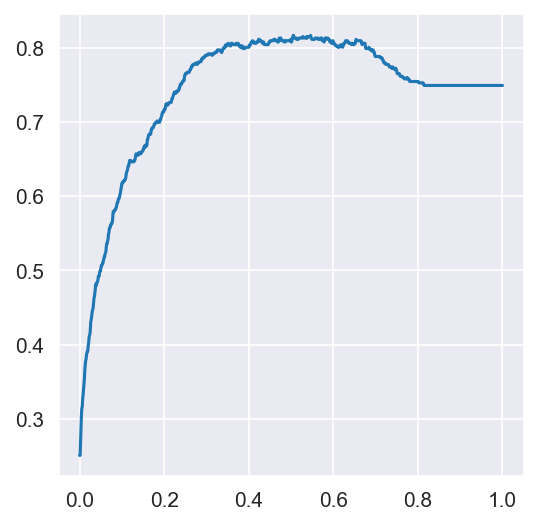

In [158]:
# Evenly-spaced vector
threshold = np.linspace(0,1,1001)

results = {}

# Looping through different threshold values
for t in threshold:

    churn_decision = (y_pred >= t)

    results[t] = (y_val == churn_decision).mean()

# Optimum threshold and accuracy
print('Optimum threshold: {0} Max accuracy: {1}'.format(
    max(results, key=results.get), round(results[max(results, key=results.get)],3)
    ))

# Visualising results

x, y = zip(*results.items())

plt.figure(figsize=(4,4), dpi=150)
sns.set_style('darkgrid')
sns.lineplot(x=x, y=y); 

In [11]:
# Thresholds of interest
print('Threshold: {0} Accuracy: {1}'.format(0.00, round(results[0],3)))
print('Threshold: {0} Accuracy: {1}'.format(1.00, round(results[1],3)))

Threshold: 0.0 Accuracy: 0.274
Threshold: 1.0 Accuracy: 0.726


Results of varying the classification threshold reveal that a threshold of 0.515 yields the highest accuracy. However, from our lineplot we notice an imbalance in the dataset, namely the difference in accuracy between 0.00 and 1.00 thresholds.

Threshold = 1.00 having an accuracy of 72.6% means that if we were to predict none of our customers to churn then our model would have 72.6% accuracy. This clearly demonstrates that our sample dataset contains an imbalanced amount of churning and non-churning users.

So, whilst our model might be ~80% accurate on the sample data we have no idea of knowing how the model will perform on more-balanced data. This calls for additional evaluation metrics.

### Confusion Matrix

![title](Confusion_Matrix.png)

A confusion table/matrix allows us to classify model outputs into the following:

- True positive
- False positive
- False negative
- True negative

These classifications enable us to define two particular metrics:

1. Precision
2. Recall

### Precision

$$\text{Precision} = \frac{TP}{TP + FP}$$

The fraction of positive predictions which are accurate

Example: A precision of 0.6 would suggest that, out of all of the users predicted to churn, 60% churned

### Recall

$$\text{Recall} = \frac{TP}{TP + FN}$$

The fraction of positive outcomes predicted correctly

Example: A recall of 0.4 would suggest that, out of all of the users who churned, 40% were predicted as churning

Having defined precision and recall, we can calculate both metrics for our model

### Calculating Metrics

In [12]:
def get_metrics(y_val, y_pred, t):

    # Dataset outcomes
    actual_pos = (y_val == 1)
    actual_neg = (y_val == 0)
    
    # Predicted outcomes
    pred_pos = (y_pred >= t)
    pred_neg = (y_pred  < t)

    # Classifying outcomes
    tp = (actual_pos & pred_pos).sum()
    fp = (actual_neg & pred_pos).sum()
    fn = (actual_pos & pred_neg).sum()
    tn = (actual_neg & pred_neg).sum()

    # Calculating metrics
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall

In [13]:
precision, recall = get_metrics(y_val, y_pred, 0.5)

round(precision,3), round(recall,3)

(0.675, 0.544)

Our model has a precision score of 67.5% and a recall of 54.5%, which can be interpreted as our model making accurate positive predictions 67.5% of the time and accurately identifying 54.5% of total churn users, respectively. Neither of these scores are particularly impressive, and thus stress the importance of using additional metrics to evaluate models, which according to accuracy, are well-performing.

### Receiver Operating Characteristics (ROC) Curves

Additional means to evaluating models based on True Positive Rate (TPR) and False Positive Rate (FPR), both of which can be computed using the confusion matrix.

### True Positive Rate

$$\text{True Positive Rate} = \frac{TP}{TP + FN} = \text{Recall}$$

Fraction of true positives amongst all positive cases (same as recall)

### False Positive Rate

$$\text{False Positive Rate} = \frac{FP}{TN + FP}$$

Fraction of false positives amongst all negative cases

### Calculating TPR and FPR

Let us append two lines to our get_metrics function to calculate TPR and FPR.

In [14]:
def get_metrics(y_val, y_pred, t):

    # Dataset outcomes
    actual_pos = (y_val == 1)
    actual_neg = (y_val == 0)
    
    # Predicted outcomes
    pred_pos = (y_pred >= t)
    pred_neg = (y_pred  < t)

    # Classifying outcomes
    tp = (actual_pos & pred_pos).sum()
    fp = (actual_neg & pred_pos).sum()
    fn = (actual_pos & pred_neg).sum()
    tn = (actual_neg & pred_neg).sum()

    # Calculating metrics
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    tpr = recall
    fpr = fp / (fp + tn)

    return precision, recall, tpr, fpr

In [15]:
precision, recall, tpr, fpr = get_metrics(y_val, y_pred, 0.5)

round(precision,3), round(recall,3), round(tpr, 3), round(fpr, 3)

(0.675, 0.544, 0.544, 0.099)

Alternatively, we can use scikit-learn to calculate the true and false positive rates.

In [72]:
from sklearn.metrics import roc_curve

# Computing components for plotting ROC curves
fpr, tpr, t = roc_curve(y_val, y_pred)

t_index = min(range(len(t)), key=lambda i: abs(t[i] - 0.5))

round(tpr[t_index], 3), round(fpr[t_index], 3)

(0.544, 0.101)

### Plotting ROC Curve

Text(0.5, 1.0, 'ROC Curve')

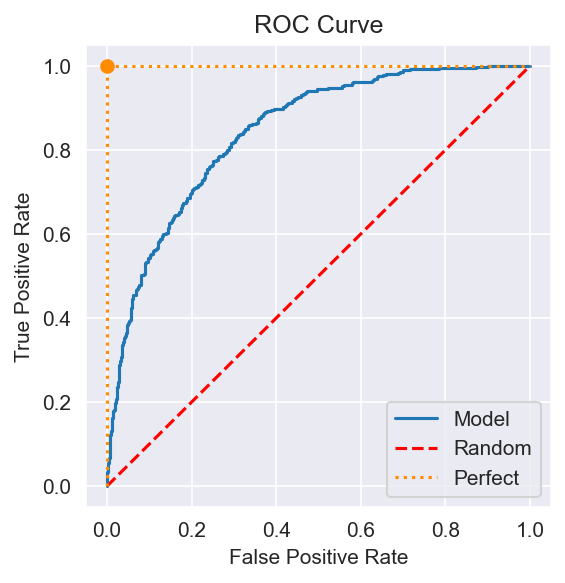

In [159]:
# Figure customisation
plt.figure(figsize=(4,4), dpi=150)

# Plotting model ROC curve 
plt.plot(fpr,tpr, label='Model')

# Plotting random model (baseline) ROC curve
plt.plot([0,1], linestyle='dashed', label='Random', color='r')

# Plotting perfect model (ideal) ROC curve
plt.plot([0,1], [1,1], color='#FF8C00', linestyle='dotted', label='Perfect')
plt.plot([0,0], [0,1], color='#FF8C00', linestyle='dotted')

plt.plot(0,1, marker='o', color='#FF8C00',)

plt.legend()

# Axis labels
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')

Ideal and random models are useful benchmarks for desirable behaviour, with the ideal model representing a perfect classifier and the random model being no better than flipping a coin or guessing. The closer our model's curve to the perfect model the better and vice versa with the random model.

Based off of the ROC curve in the figure above, we may evaluate our model as being good, but nothing special (lots of room for improvement).

### ROC Area Under Curve (AUC)

Plotting and visualising the true and false positive rates is a useful means of evalating our model's effectiveness. That said, it can be difficult to quantify the model's success from inspection alone. By calculating the area under our model's ROC curve we can put a number to our model's effectiveness; thus, evaluating it effectively.

With the ideal model having an AUC of 1 and the random model 0.5, we expect models to have an ROC AUC between 0.5 and 1.

$$\frac{1}{2} \leq (\text{AUC}) \leq 1$$

Calculating AUC is trivial using scikit-learn:

In [75]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred)

0.8438251814484473

Our binary classification model has an AUC of 0.84, which is certainly closer to 1 than 0.5 but could be a lot closer.

AUC scores can also be interpreted as follows:

"Given a randomly selected positive (user predicted to churn) and negative entry (user predicted to not churn), the AUC score is precisely the probability that the positive example will have a higher score than the negative example".

$$\text{AUC} = P( (\text{Positive Entry Score}) > \text{(Negative Entry Score)} )$$

### K-Fold Cross Validation

Now that we have defined metrics to evaluate our model we want to be sure that the metrics are not skewed by our validation framework. By cross validating we can improve our confidence in our results.

K-Fold cross validation essentially involves splitting our full train (initial training + validation splits) set into K subsets (folds) and evaluating the model K times, with each iteration using K-1 subsets for training and 1 subset of validation.  

![title](K-Folds%20diagram.png)

Outline:

1. Define function for training model
2. Define function for predicted results
3. Create Kfold object
4. Iterate K folds

In [101]:
# Model for training classifier model
def train(df_train, y_train, C=1.0):

    # Initialising sklearn dictionary vectoriser (sparse matrix == False)
    dv = DictVectorizer(sparse=False)

    # Creating dictionary of training features
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    # Transforming dictionary to formatted feature matrix using DictVectoriser
    X_train = dv.fit_transform(dicts)

    # Initialising logistic regression model using sklearn
    model = LogisticRegression(C=C, max_iter=1000)

    # Training model on train split
    model.fit(X_train, y_train)

    return dv, model

In [102]:
dv, model = train(df_train, y_train, 0.001)

In [104]:
# Function for making generating model predictions
def predict(df, dv, model):
    
    # Creating dictionary of training features
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    # Transforming dictionary to formatted feature matrix using DictVectoriser
    X = dv.transform(dicts)

    # Obtaining probabilistic predictions for validation split
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [105]:
y_pred = predict(df_val, dv, model)

After writing functions to train binary classification models and make predictions using them we can use KFold from scikit-learn to easily generate K-Fold validation sets. 

In [96]:
from sklearn.model_selection import KFold

In [138]:
# Generating indices for 10 shuffled splits
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

# Empty array to store scores
scores = []

# Indices for train and validation parts
for train_idx, val_idx in kfold.split(df_full_train):

    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('Mean AUC: {0:.3f}\nSTD: {1:.3f}'.format(np.mean(scores),np.std(scores)))

Mean AUC: 0.840
STD: 0.013


Running a 10-fold cross validation yields a mean AUC of 0.84 and a standard deviation of 0.013. This is a good score because it aligns with our original AUC estimation and implies consistency.

In [139]:
# Function for monitoring progress
from tqdm.auto import tqdm

### Parameter Tuning

With a means of validating our model, we can now investigate how model performance is influenced by varied parameters. Analysis enables us to optimise our model before evaluating on the final test set. For the binary classification model we can vary C, a hyperparameter describing regularization. Varying C alters the weightings assigned to the training data and can increasing the chance of overfitting if used innapropriately.

In [156]:
# Varying regularization stength
for C in tqdm([0.00001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10]):

    # Generating indices for 10 shuffled splits
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)

    # Empty array to store scores
    scores = []

    # Indices for train and validation parts
    for train_idx, val_idx in kfold.split(df_full_train):

        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C: {0:<6} Mean: {1:.4f} STD: {2:.4f}'.format(C, np.mean(scores),np.std(scores)))

  0%|          | 0/8 [00:00<?, ?it/s]

C: 1e-05  Mean: 0.8038 STD: 0.0131
C: 0.001  Mean: 0.8263 STD: 0.0124
C: 0.01   Mean: 0.8404 STD: 0.0122
C: 0.1    Mean: 0.8406 STD: 0.0118
C: 0.5    Mean: 0.8412 STD: 0.0112
C: 1      Mean: 0.8404 STD: 0.0127
C: 5      Mean: 0.8413 STD: 0.0120
C: 10     Mean: 0.8413 STD: 0.0119


Varying the regularization strength reveals a general consistency across values, with AUC falling down with exponentially smaller values (e.g.: C = 1e-05). Interestingly, there is not much variation from the default value of C = 1.0.

### Training Final Model

Now that we have trialed several different regularization parameters, we can choose the optimal value and train our model on the full training set, followed by evaluation on the test set. 

In [153]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

Interestingly, the model performs better (not by much) on the test set which is a nice bonus. This situation is comparable to performing better on a private Kaggle leaderboard than the public one (not unheard of).

This concludes our exploration of evaluation metrics. We have discussed why additional metrics are important and demonstrated the implementation of several different types/methods.